<a href="https://colab.research.google.com/github/Leotzu/cartpole_Q-learning/blob/main/cartpole_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dependencies for rendering gym envs in Colab

!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipydisplay
from pyvirtualdisplay import Display
import time

%matplotlib inline

In [3]:
# Initialize Q-table
# Our state space = 4
# and action space = 2 (left or right)

def Qtable(state_space, action_space, bin_size = 30):
    # bins 
    bins = [np.linspace(-4.8, 4.8, bin_size),
            np.linspace(-4, 4, bin_size),
            np.linspace(-0.418, 0.418, bin_size),
            np.linspace(-4, 4, bin_size)]
    
    # q_table initialized with random values
    # q_table shape = (30, 30, 30, 2)
    q_table = np.random.uniform(low=-1, high=1, size=([bin_size] * state_space + [action_space]))

    return q_table, bins

def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

In [4]:
def renderEnv(env, q_table, bins):
    # start image display
    display = Display(visible=0, size=(400, 300))
    display.start()

    # get initial state observation
    current_state = Discrete(env.reset(),bins)

    # To decrease render time, only call imshow() once, and just set_data() every iteration
    img = plt.imshow(env.render(mode='rgb_array'))
    for i in range(75):
      action = np.argmax(q_table[current_state])
      observation, reward, done, info = env.step(action)
      current_state = Discrete(observation, bins)
      img.set_data(env.render(mode='rgb_array'))

      ipydisplay.clear_output(wait=True)
      ipydisplay.display(plt.gcf())
      '''
      # this will stop the simulation after a sufficiently bad tilt of the pole has been reached
      if done:
        break
      '''
    ipydisplay.clear_output(wait=True)
    env.close()

In [10]:
# Train and plot the reward results
def Q_learning(q_table, bins, episodes = 5000, alpha = 0.1, gamma = 0.95, epsilon = 0.2, timestep = 5000):
    # initializations
    rewards = 0
    solved = False 
    steps = 0 
    runs = [0]
    # data dictionary for plotting results
    data = {'max' : [0], 'avg' : [0]}
    start = time.time()
    
    for episode in range(1,episodes+1):
        # get initial state observation
        current_state = Discrete(env.reset(),bins)
        score = 0
        done = False
        temp_start = time.time()
        
        while not done:
            steps += 1 
            ep_start = time.time()
                
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
            
            observation, reward, done, info = env.step(action)
            next_state = Discrete(observation,bins)

            score += reward
            
            if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-alpha)*current_q + alpha*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q

            current_state = next_state
            
        # End of the loop update
        else:
            rewards += score
            runs.append(score)
            # check if "solved" during one of the runs (i.e., stays balanced for a sufficiently long time)
            if score > 195 and steps >= 100 and solved == False: # considered as a solved
                solved = True
                print(f'First solved in episode : {episode} in time {time.time()-ep_start}')
        
        # Timestep value update
        if episode%timestep == 0:
            print(f'Episode : {episode} | Avg Reward = {rewards/timestep} | Max Reward  {max(runs)} | Time : {time.time() - ep_start}')
            data['max'].append(max(runs))
            data['avg'].append(rewards/timestep)
            if rewards/timestep >= 195: 
                print(f'First solved in episode : {episode}')
            rewards, runs= 0, [0] 

    # Plot the maxvand avg reward earned at each timestep
    ep = [i for i in range(0,episodes + 1,timestep)]
    plt.plot(ep, data['max'], label = 'Max')
    plt.plot(ep, data['avg'], label = 'Avg')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(loc = "upper left")
        
    env.close()

In [6]:
# Create cartpole environment from openAI gym
env = gym.make('CartPole-v0')
print(env.observation_space.low,"\n",env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] 
 [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [ ]:
# Initialize Q-table and bins
q_table, bins = Qtable(len(env.observation_space.low), env.action_space.n)

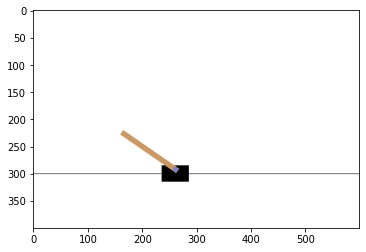

In [8]:
# Test policy before training (should be bad)
renderEnv(env, q_table, bins)

First solved in episode : 2 in time 4.267692565917969e-05
Episode : 500 | Avg Reward = 142.038 | Max Reward  200.0 | Time : 0.0001366138458251953
Episode : 1000 | Avg Reward = 155.728 | Max Reward  200.0 | Time : 0.00012993812561035156
Episode : 1500 | Avg Reward = 157.672 | Max Reward  200.0 | Time : 6.318092346191406e-05
Episode : 2000 | Avg Reward = 162.91 | Max Reward  200.0 | Time : 7.271766662597656e-05
Episode : 2500 | Avg Reward = 163.764 | Max Reward  200.0 | Time : 6.29425048828125e-05
Episode : 3000 | Avg Reward = 161.434 | Max Reward  200.0 | Time : 6.794929504394531e-05
Episode : 3500 | Avg Reward = 171.3 | Max Reward  200.0 | Time : 6.079673767089844e-05
Episode : 4000 | Avg Reward = 163.868 | Max Reward  200.0 | Time : 6.4849853515625e-05
Episode : 4500 | Avg Reward = 166.538 | Max Reward  200.0 | Time : 6.580352783203125e-05
Episode : 5000 | Avg Reward = 170.494 | Max Reward  200.0 | Time : 6.341934204101562e-05


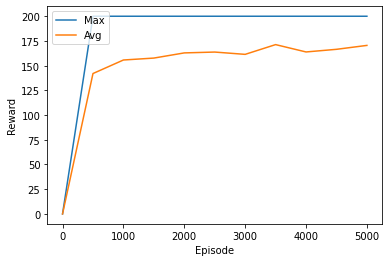

In [11]:
# Train

# hyperparameters
alpha = 0.15 # learning rate
gamma = 0.995 # discount rate
epsilon = 0.2
episodes = 5000

Q_learning(q_table, bins, episodes, alpha, gamma, epsilon, timestep = 500)

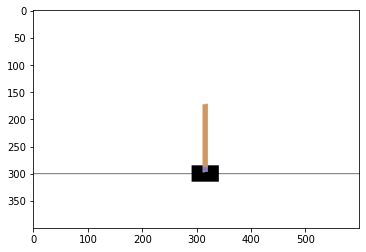

In [12]:
# Test policy after training
renderEnv(env, q_table, bins)